# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation != 'relu':
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128)

        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256)

        # Вихідний шар
        self.output_layer = DenseLayer(256, 10)


    def __call__(self, x):
      # Місце для вашого коду
      x = self.layer1(x, activation='relu')
      x = self.layer2(x, activation='relu')
      self.output_layer(x, activation='softmax')

      # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
      # Робимо ми це для того, щоб
      # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
      # Приналежності вхідного об'єкта до одного з 10 класів

      return self.output_layer(x, activation='softmax')

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримання класу з найвищою ймовірністю
    predicted_classes = tf.argmax(y_pred, axis=1)

    # Перетворення y_true, якщо воно ще не в форматі тензору
    true_classes = tf.cast(y_true, tf.int64)

    # Обчислення точності
    correct_predictions = tf.equal(predicted_classes, true_classes)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as tape:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримуємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = tape.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

batch_x, batch_y = next(iter(train_data))
loss = train(neural_net, batch_x, batch_y)
print(f"Training loss: {loss.numpy()}")

Training loss: 4080.900390625


In [ ]:
# Тренування мережі

def train_cycle(neural_net, train_data, training_steps, display_step):

    loss_history = [] # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
    accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.

    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Оновлюємо ваги нейронної мережі та отримуємо втрату
        loss = train(neural_net, batch_x, batch_y)
        # Обчислюємо точність на поточному батчі
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)

        # Зберігаємо історію втрати та точності для моніторингу
        if step % display_step == 0:
            loss_history.append(loss.numpy())
            accuracy_history.append(acc.numpy())
            print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

    return loss_history, accuracy_history

# Приклад виклику функції тренувального циклу
loss_history, accuracy_history = train_cycle(neural_net, train_data, training_steps, display_step)


Step 100, Loss: 363.2981872558594, Accuracy: 0.67578125
Step 200, Loss: 250.89422607421875, Accuracy: 0.7734375
Step 300, Loss: 210.0054168701172, Accuracy: 0.76171875
Step 400, Loss: 168.80255126953125, Accuracy: 0.82421875
Step 500, Loss: 135.15444946289062, Accuracy: 0.86328125
Step 600, Loss: 131.51519775390625, Accuracy: 0.87890625
Step 700, Loss: 138.14736938476562, Accuracy: 0.8671875
Step 800, Loss: 156.64178466796875, Accuracy: 0.8515625
Step 900, Loss: 120.1070556640625, Accuracy: 0.8671875
Step 1000, Loss: 110.19026947021484, Accuracy: 0.87109375
Step 1100, Loss: 90.71807861328125, Accuracy: 0.9140625
Step 1200, Loss: 88.83973693847656, Accuracy: 0.91015625
Step 1300, Loss: 83.71826171875, Accuracy: 0.91796875
Step 1400, Loss: 75.00084686279297, Accuracy: 0.91796875
Step 1500, Loss: 74.91181945800781, Accuracy: 0.93359375
Step 1600, Loss: 81.73239135742188, Accuracy: 0.9140625
Step 1700, Loss: 89.64644622802734, Accuracy: 0.91796875
Step 1800, Loss: 102.82334899902344, Accur

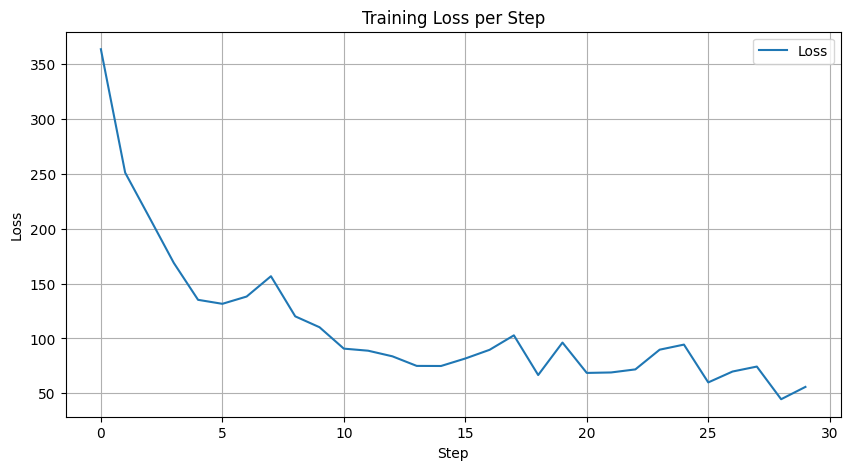

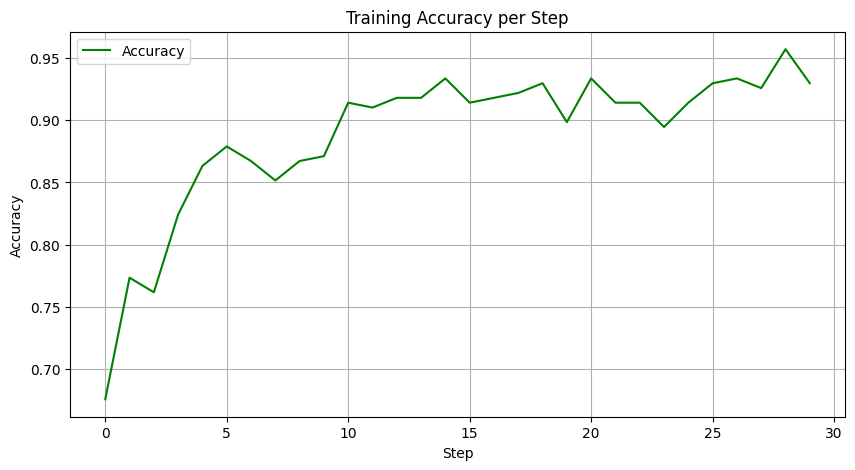

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss')
plt.title('Training Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Training Accuracy per Step')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def test_model(model, test_data):
    # Змінні для збору точності всіх батчів
    total_correct = 0
    total_samples = 0

    # Ітеруємо по тестових даних
    for batch_x, batch_y in test_data:
        pred = model(batch_x)
        # Використовуємо функцію точності, яку ми вже визначали
        acc = accuracy(pred, batch_y)
        total_correct += acc.numpy() * batch_x.shape[0]  # Обрахунок загальної кількості правильних передбачень
        total_samples += batch_x.shape[0]  # Загальна кількість зразків

    # Обрахунок загальної точності
    overall_accuracy = total_correct / total_samples
    return overall_accuracy

# Створення датасету тестових даних
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(1)  # Тут можна налаштувати розмір батчу, якщо потрібно

# Тестування моделі
model_accuracy = test_model(neural_net, test_data)
print(f"Accuracy on test data: {model_accuracy * 100:.2f}%")

Accuracy on test data: 90.72%


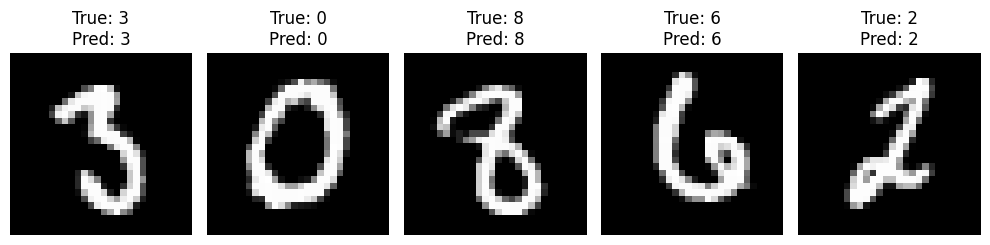

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Вибираємо випадкові індекси для зображень
random_indices = np.random.choice(x_test.shape[0], 5, replace=False)

# Отримуємо зображення та мітки
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Використовуємо модель для передбачення
sample_predictions = neural_net(sample_images).numpy()
predicted_classes = np.argmax(sample_predictions, axis=1)

# Візуалізація результатів
plt.figure(figsize=(10, 5))
for i, (image, label, prediction) in enumerate(zip(sample_images, sample_labels, predicted_classes)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(image, (28, 28)), cmap='gray')
    plt.title(f"True: {label}\nPred: {prediction}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Із заданими умовою параметрами, при використанні інструментів які були надані умовами задачі, було оцінено точність моєї моделі в 90%.
## Проте можна було б спробувати використати інші види шарів, змінити гіперпараметри (швидкість навчання, оптимізатор, розмір батчу та кількість епох), використання більш потужних фреймворків з автоматизованими техніками оптимізації, як наприклад Keras, тощо.